# Introduction
Pipeline from the paper [Persistence diagrams as morphological signatures of cells: A method to measure and compare cells within a population](https://files.yossi.eu/manuscripts/2310.20644.pdf) by Yossi Bokor Bleile, Pooja Yadav, Patrice Koehl, and Florian Rehfeldt.

The following packages need to be installed: 
- [Correa](correa.yossi.eu)
- plotly
- pandas
- sklearn
- numpy
- matplotlib
- tifffile


We begin the analysis by obtaining a persistence diagram for each cell in the population, as a summary of the morophology of the cell.

Below is the anlysis for `X1`, which can be repeated for `Y1` by replacing `X1` with `Y1` as appropriate and the running the relevant cells again.


## Import modules

In [18]:
import os
import correa
import pandas
import tifffile
import plotly.express as px
import plotly.figure_factory as ff		
import plotly.io as pio
import plotly.graph_objects as go
from sklearn import manifold, cluster, decomposition, metrics, preprocessing
import numpy
import scipy.cluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import ClusterWarning
from matplotlib import pyplot as plt
import matplotlib
from scipy.spatial.distance import squareform
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

pio.renderers.default = "browser" #set the renderer

## Custom functions for the analysis

We next define some custom functions to make creating the dendrograms easier.


In [16]:
#set colours
def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)
hex_list = []
for c in px.colors.qualitative.Set1:
	hex_list.append(rgb_to_hex(int(c.replace("rgb(","").replace(")","").split(",")[0]),int(c.replace("rgb(","").replace(")","").split(",")[1]), int(c.replace("rgb(","").replace(")","").split(",")[2])))
 
def plot_dendrogram(model, **kwargs):
	# Create linkage matrix and then plot the dendrogram
	# create the counts of samples under each node
	counts = numpy.zeros(model.children_.shape[0])
	n_samples = len(model.labels_)
	for i, merge in enumerate(model.children_):
		current_count = 0
		for child_idx in merge:
			if child_idx < n_samples:
				current_count += 1  # leaf node
			else:
				current_count += counts[child_idx - n_samples]
		counts[i] = current_count
	linkage_matrix = numpy.column_stack([model.children_, model.distances_, counts]).astype(float)
	# Plot the corresponding dendrogram
	plt.figure(figsize=(2000,2000))
	plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
	plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
	dendrogram(linkage_matrix, **kwargs)

def generate_rand_index(cluster_df : pandas.DataFrame, to_compare : list):
	r_ind = pandas.DataFrame(columns=to_compare, index=to_compare)
	for i in to_compare:
		for j in to_compare:
			r_ind.loc[j,i] = metrics.rand_score(cluster_df[i], cluster_df[j])
	return r_ind

def population_percentages(df : pandas.DataFrame, clustering : str):
	labels = [int(c) for c in df[clustering]]
	counts = [0 for i in range(max(labels)+1)]
	for l in labels:
		counts[l]+=1
	percentages = [c/len(labels) for c in counts]
	return percentages, counts

def analysis(dists : pandas.DataFrame, n_colours : int , cluster_numbers : list,  name : str,  dir : str, group = False, exclude : list = [], show2d = False, showElbow=False, colour_list=hex_list, save=True, show=True):
	#colour order is red, purple, blue, green
	if group == False:
		inds = dists.index
		dists = dists
		if len(exclude) != 0:
			print("Need to exclude: ", exclude)
			inds = []
			for f in dists.index:
				if f not in exclude:
					inds.append(f)
			dists = dists.loc[inds, inds]
			print("now dists has shape: ", dists.shape)
	else:
		inds = []
		for f in dists.index:
			if group in f and f not in exclude:
				inds.append(f)
		dists = dists.loc[inds, inds]
	df = pandas.DataFrame(index=inds)
	embed = manifold.MDS(3, dissimilarity='precomputed', random_state=1, normalized_stress="auto").fit_transform(dists.to_numpy())
	df["x"] = embed[:,0]
	df["y"] = embed[:,1]
	df["z"] = embed[:,2]
	silhouette_samples = []
	silhouette_score = []
	linkage_matrices = []
	avg = cluster.AgglomerativeClustering(distance_threshold=None, n_clusters=n_colours, linkage="average")
	avg = avg.fit(dists.to_numpy())
	dflt = "#000000"
	D_leaf_colors = {dists.index[i]: colour_list[avg.labels_[i]] for i in range(len(avg.labels_))}
	#Average
	for link in ["average", "complete", "single", "ward"]:
		linkage = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=link)
		linkage = linkage.fit(dists.to_numpy())
		counts = numpy.zeros(linkage.children_.shape[0])
		n_samples = len(linkage.labels_)
		for i, merge in enumerate(linkage.children_):
			current_count = 0
			for child_idx in merge:
				if child_idx < n_samples:
					current_count += 1  # leaf node
				else:	
					current_count += counts[child_idx - n_samples]
			counts[i] = current_count
		linkage_matrix = numpy.column_stack([linkage.children_, linkage.distances_, counts]).astype(float)
		linkage_matrices.append(linkage_matrix)
		# notes:
		# * rows in Z correspond to "inverted U" links that connect clusters
		# * rows are ordered by increasing distance
		# * if the colors of the connected clusters match, use that color for link
		link_cols = {}
		for i, i12 in enumerate(linkage_matrix[:,:2].astype(int)):
			c1, c2 = (link_cols[x] if x > len(linkage_matrix) else D_leaf_colors[dists.index[x]] for x in i12)
			if c1 == c2:
				link_cols[i+1+len(linkage_matrix)] = c1
			else:
				if i12[0] < n_samples:
					link_cols[i+1+len(linkage_matrix)] = D_leaf_colors[dists.index[i12[0]]]
				elif i12[1] < n_samples:
					link_cols[i+1+len(linkage_matrix)] = D_leaf_colors[dists.index[i12[1]]]
				else:
					link_cols[i+1+len(linkage_matrix)] = dflt
		# Dendrogram
		D = dendrogram(Z=linkage_matrix, labels=dists.index, color_threshold=None, no_labels=True, link_color_func=lambda x: link_cols[x])
		#plt.xlabel(name+" "+link)
		plt.yticks([])
		if save:
			plt.savefig(dir+"/"+name.replace(" ","_")+"_"+link+"_dendrogram.png")
		plt.show()
	sse = []
	for link in ["average", "complete", "single", "ward"]:
		for k in cluster_numbers:
			linkage = cluster.AgglomerativeClustering(distance_threshold=None, n_clusters=k, linkage=link)
			linkage = linkage.fit(dists.to_numpy())
			labels = linkage.labels_
			labels = [str(c) for c in labels]
			df[link+str(k)] = labels
			sil_score = metrics.silhouette_score(dists, df[link+str(k)], metric="precomputed")
			silhouette_score.append(sil_score)
			sil_samps = metrics.silhouette_samples(dists, df[link+str(k)], metric="precomputed")
			silhouette_samples.append([sil_samps])
			fig = px.scatter(df, x='x', y='y',color=link+str(k), title=name+" ("+link+" "+str(k)+")", hover_data=[df.index], width=800, height=600, color_discrete_map={
                "0": hex_list[0], "1": hex_list[1],"2": hex_list[1],"2": hex_list[2], "3": hex_list[3]})
			fig.update_traces(marker={'size': 5})
			if show2d:
				fig.show()
			fig.write_image(dir+"/"+name.replace(" ","_")+"_"+link+str(k)+"_2D.png")
	if showElbow:
		plt.plot(cluster_numbers, sse)
		plt.title("Elbow Method")
		plt.xlabel("Number of Clusters")
		plt.xticks(cluster_numbers)
		plt.ylabel("SSE")
		plt.savefig(dir+"/"+name.replace(" ","_")+"_kmeans-elbow.png")
		fig.show()
	df.to_csv(dir+"/"+name.replace(" ","_")+"_df.csv")
	rand_ind_tables_latex = []
	percentages_dict = {}
	for k in cluster_numbers:
		rand_ind_tables_latex.append(generate_rand_index(df, ["average"+str(k), "complete"+str(k), "single"+str(k),"ward"+str(k)]).to_latex())
		print("cluster sizes and percentages are:")
		percentages_dict["average{}".format(k)], counts = population_percentages(df, "average"+str(k))
		print("average{}".format(k), counts, percentages_dict["average{}".format(k)])
		percentages_dict["complete{}".format(k)], counts = population_percentages(df, "complete"+str(k))
		print("complete{}".format(k), counts, percentages_dict["complete{}".format(k)])
		percentages_dict["single{}".format(k)], counts = population_percentages(df, "single"+str(k))
		print("single{}".format(k), counts, percentages_dict["single{}".format(k)])
		percentages_dict["ward{}".format(k)], counts = population_percentages(df, "ward"+str(k))
		print("ward{}".format(k), counts, percentages_dict["ward{}".format(k)])
		#percentages_dict["kmeans++{}".format(k)] = population_percentages(df, "kmeans++"+str(k))
		#print("kmeans++{}".format(k), percentages_dict["kmeans++{}".format(k)])
	return df, silhouette_score, silhouette_samples, rand_ind_tables_latex, percentages_dict, dists, linkage_matrices

def get_main_population(analysis, cluster : str, dists : pandas.DataFrame):
	main_id = analysis[4][cluster].index(max(analysis[4][cluster]))
	main_index= analysis[0].index[analysis[0][cluster] == str(main_id)]
	return dists.loc[main_index,main_index]

def purity(merges, clus : set, n_objs):
	dct = dict([(i, {i}) for i in range(n_objs)])
	for i, row in enumerate(merges, n_objs):
		dct[i] = dct[row[0]].union(dct[row[1]])
		del dct[row[0]]
		del dct[row[1]]
		for c in list(dct.values()):
			if clus.issubset(c):
				return c, (n_objs-len(c))/(n_objs-len(clus))


# Example Dataset

In [34]:
dataset = "Y1" #select the dataset to analyse and the set the correct width and height of the images
if dataset == "X1":
	width=1500 #we need to set the largest width of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	height=1692 #we need to set the largest height of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	scale_factor = 0.3155
	files = os.listdir(dataset+"/cell/raw_images")
	cell_names = [int(file[0:3]) for file in files if file.endswith('.tif')]
elif dataset == "X2":
	width=1455
	height=1584
	scale_factor = 0.3155
	files = os.listdir(dataset+"/cell/raw_images")
	cell_names = [int(file[0:3]) for file in files if file.endswith('.tif')]
elif dataset == "X3":
	width=1919
	height=1467
	scale_factor = 0.3155
	files = os.listdir(dataset+"/cell/raw_images")
	cell_names = [int(file[0:3]) for file in files if file.endswith('.tif')]
elif dataset == "Y1":
	width=1226 #we need to set the largest width of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	height=1088 #we need to set the largest height of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	scale_factor = 0.1639
	files = os.listdir(dataset+"/cell/raw_images")
	cell_names = [int(file[0:3]) for file in files if file.endswith('.tif')]
elif dataset == "X1+Y1":
	width_X1 = 1500
	height_X1 = 1692
	scale_factor_X1 = 0.3155
	width_Y1 = 1226
	height_Y1 = 1088
	scale_factor_Y1 = 0.1639
	files_X1 = os.listdir("X1/cell/raw_images")
	files_Y1 = os.listdir("Y1/cell/raw_images")
	cell_names_X1 = ["X1_"+str(int(file[0:3])) for file in files_X1 if file.endswith('.tif')]
	cell_names_Y1 = ["Y1_"+str(int(file[0:3])) for file in files_Y1 if file.endswith('.tif')]
	files = []
	files.extend(files_X1)
	files.extend(files_Y1)
	cell_names = []
	cell_names.extend(cell_names_X1)
	cell_names.extend(cell_names_Y1)
else:
	raise ValueError("Dataset not supported")

n_cells = len(cell_names)


First, we will load the file containing the center of the nucleus for each cell.

Next, for each cell will caculate the persistence diagram using a radial function based at the center of the nucles. We do need to translate the center of the nucleus into the same frame as the contour is in. This is due to the way FilamentSensor extracts the contour of each cell in a directory. The appropriate `height` and `width` values can be found in the [FilamentSensor2](https://filament-sensor.de/) log file.

In [36]:
if dataset == "X1+Y1":
	centers_X1 = pandas.read_csv("X1/Nuc_Cm_X1.csv", index_col="filename") #Load the center of the nucleus, labled by the nucleus file name
	centers_Y1 = pandas.read_csv("Y1/Nuc_Cm_Y1.csv", index_col="filename") #Load the center of the nucleus, labled by the nucleus file name
else:
	centers = pandas.read_csv(dataset+"/Nuc_Cm_"+dataset+".csv", index_col="filename") #Load the center of the nucleus, labled by the nucleus file name

In [ ]:
contours = []

for name in cell_names[:1]:
	if dataset == "X1+Y1":
		if "X1_" in name:
			i = int(name.split("_")[1])
			ds = "X1"
			height = height_X1
			width = width_X1
			actin = tifffile.imread(ds+"/cell/raw_images/"+str("%03d" % i)+".tif") #we need to know the size of the original image to shift the center of the nucleus to the correct position
			height_diff = height - actin.shape[0]
			width_diff = width - actin.shape[1]	
			fa = [centers_X1.loc[i,"X_m"]+width_diff/2,centers_X1.loc[i,"Y_m"]+height_diff/2]
			scale_factor = scale_factor_X1
		elif "Y1_" in name:
			i = int(name.split("_")[1])
			ds = "Y1"
			height = height_Y1
			width = width_Y1
			actin = tifffile.imread(ds+"/cell/raw_images/"+str("%03d" % i)+".tif") #we need to know the size of the original image to shift the center of the nucleus to the correct position
			height_diff = height - actin.shape[0]
			width_diff = width - actin.shape[1]
			fa = [centers_Y1.loc[i,"X_m"]+width_diff/2,centers_Y1.loc[i,"Y_m"]+height_diff/2]
			scale_factor = scale_factor_Y1
		else:
			raise ValueError("Cell name not supported")
	else:
		i = name
		ds = dataset
		height = height
		width = width
		actin = tifffile.imread(ds+"/cell/raw_images/"+str("%03d" % i)+".tif") #we need to know the size of the original image to shift the center of the nucleus to the correct position
		height_diff = height - actin.shape[0]
		width_diff = width - actin.shape[1]
		fa = [centers.loc[i,"X_m"]+width_diff/2,centers.loc[i,"Y_m"]+height_diff/2]
	print("ds is {} with scale factor {}".format(ds, scale_factor))

	c_i = correa.create_polygon_focal_point(ds+"/cell/contours/"+str("%03d" % i)+"_contour.csv", fa, scale_by_area=False, convert_to_microns_factor=scale_factor)
	contours.append(c_i)
 

We can also plot the contours and mark the center of the nucleus

In [ ]:
for i in cell_names: #cell number we want to look at
	contour = pandas.read_csv(dataset+"/cell/contours/"+str("%03d" % i)+"_contour.csv",header=None)
	actin = tifffile.imread(dataset+"/cell/raw_images/"+str("%03d" % i)+".tif")
	nucleus = tifffile.imread(dataset+"/nucleus/raw_images/"+str("%03d" % i)+".tif")
	height_diff = height - actin.shape[0]
	width_diff = width - actin.shape[1]
	center = pandas.DataFrame([[centers.loc[i,"X_m"]+width_diff/2,centers.loc[i,"Y_m"]+height_diff/2]], columns=["x", "y"])
	fig_data = px.scatter(contour, x=0, y=1, width=800, height=600).data
	fig_data = fig_data + px.scatter(center, x="x", y="y").update_traces(marker={'size': 5, 'color': 'Red'}).data
	fig = go.Figure(fig_data)
	fig.show()


Once we have a persistence diagram for each cell summarising its morphology, we compute the Wasserstein distance between each pair of persistence diagrams as a (dis)similarity score for each pair of cells.

In [ ]:
w_distances = numpy.zeros((n_cells,n_cells))
for i in range(n_cells):
	for j in range(i,n_cells):
		dist = correa.wasserstein_distance(contours[i], contours[j], q=2)
		w_distances[i,j] = dist
		w_distances[j,i] = dist
		print("for {} and {} dist is {}".format(i,j,dist))


dists = pandas.DataFrame(w_distances, columns=cell_names, index=cell_names)
dists.to_csv(dataset+"/distances.csv")
dists.to_csv(dataset+"/distances.dat", header=False, index=False)

## Start doing some analysis

In [ ]:
px.imshow(w_distances,width=500, height=500).show()

In [3]:
dists = pandas.read_csv("X1+Y1/distances.csv", index_col=0)

In [12]:
# for just X1 cells
x1_cells = [name for name in dists.index if name.startswith('X1_')]
dists_x1 = dists.loc[x1_cells, x1_cells]

# Filter for just Y1 cells
y1_cells = [name for name in dists.index if name.startswith('Y1_')]
# dists_scaled_y1 = dists_scaled_by_area.loc[y1_cells, y1_cells]
dists_y1= dists.loc[y1_cells, y1_cells]




/Users/yossi/PDaMSoC-data/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9.



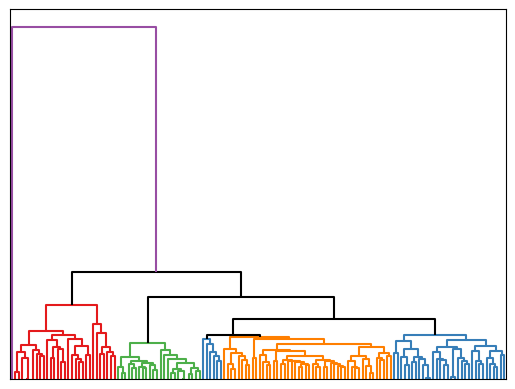

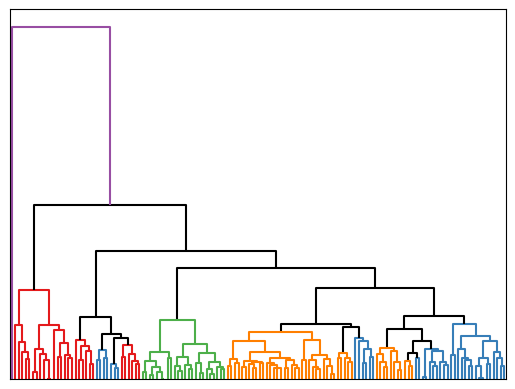

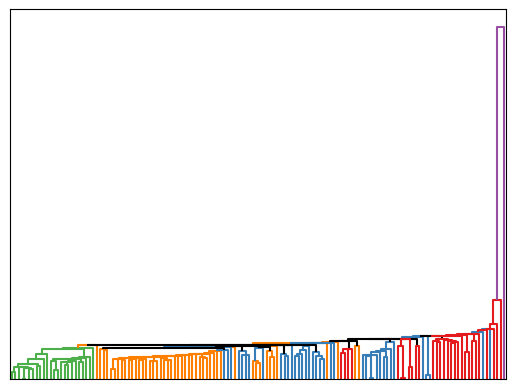

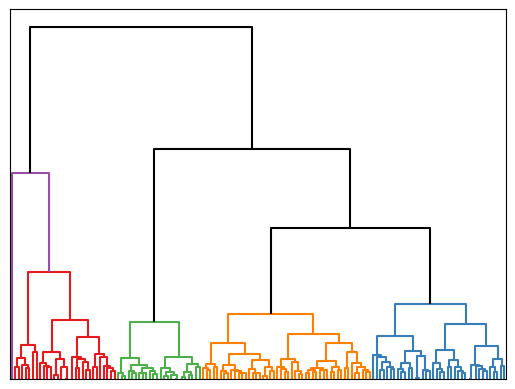

cluster sizes and percentages are:
average2 [139, 1] [0.9928571428571429, 0.007142857142857143]
complete2 [139, 1] [0.9928571428571429, 0.007142857142857143]
single2 [139, 1] [0.9928571428571429, 0.007142857142857143]
ward2 [110, 30] [0.7857142857142857, 0.21428571428571427]
cluster sizes and percentages are:
average3 [110, 1, 29] [0.7857142857142857, 0.007142857142857143, 0.20714285714285716]
complete3 [122, 1, 17] [0.8714285714285714, 0.007142857142857143, 0.12142857142857143]
single3 [138, 1, 1] [0.9857142857142858, 0.007142857142857143, 0.007142857142857143]
ward3 [30, 86, 24] [0.21428571428571427, 0.6142857142857143, 0.17142857142857143]
cluster sizes and percentages are:
average4 [29, 24, 86, 1] [0.20714285714285716, 0.17142857142857143, 0.6142857142857143, 0.007142857142857143]
complete4 [103, 19, 17, 1] [0.7357142857142858, 0.1357142857142857, 0.12142857142857143, 0.007142857142857143]
single4 [137, 1, 1, 1] [0.9785714285714285, 0.007142857142857143, 0.007142857142857143, 0.007

In [14]:
A_X1 = analysis(dists_x1, 5, [2,3,4,5], show2d=False, name=dataset, dir=dataset, save=False, show=False)

In [ ]:
A = analysis(dists, 2, [2,3,4,5,6,7,8,9,10], show2d=False, name=dataset, dir=dataset, save=False, show=False)

In [ ]:
A_main = A_not_scaled
n_c = A_main[0].shape[0]
for n_k in range(2,11):
# n_k = 2
	print("looking at "+str(n_k)+" clusters")
	for k in range(n_k):
		clus = set(())
		for i in range(len(A_main[0]["average"+str(n_k)])):
			if A_main[0]["average"+str(n_k)].iloc[i] == str(k):
				clus.add(i)
		print("cluster "+str(k)+" with size "+str(len(clus)))
		print("average: "+str(purity(A_main[6][0], clus, n_c)[1]))
		print("complete: "+str(purity(A_main[6][1], clus, n_c)[1]))
		print("single: "+str(purity(A_main[6][2], clus, n_c)[1]))
		print("ward: "+str(purity(A_main[6][3], clus, n_c)[1]))

In [ ]:
### searching for the best number of clusters that separates the cells into X1 and Y1 

y1 = [i for i in range(len(A_main[0])) if "Y1" in A_main[0].index[i]]
x1 = [i for i in range(len(A_main[0])) if "X1" in A_main[0].index[i]]

for n_k in range(2,11):
	print("looking at "+str(n_k)+" clusters")
	# for k in range(n_k):
	clus = set(x1)
	print("cluster "+str(k)+" with size "+str(len(clus)))
	print("average: "+str(purity(A_main[6][0], clus, n_c)[1]))
	print("complete: "+str(purity(A_main[6][1], clus, n_c)[1]))
	print("single: "+str(purity(A_main[6][2], clus, n_c)[1]))
	print("ward: "+str(purity(A_main[6][3], clus, n_c)[1]))

In `X1`, the heatmap and all 4 dendrograms indicate there is an outlier, so lets identify which cell this is. Using `average4` the outlier has cluster number 3.

In [ ]:
if dataset == "X1":
	for i in A_scaled[0].index:
		if int(A_scaled[0].loc[i]["average4"]) == 3:
			print("Scaled {}".format(i))
	for i in A_not_scaled[0].index:
		if int(A_not_scaled[0].loc[i]["average4"]) == 3:
			print("Not Scaled {}".format(i))

If desired we can use the `analysis` command with the `exclude` parameter to exclude cell a from our analysis.

Need to exclude:  ['X1_15']
now dists has shape:  (139, 139)


/Users/yossi/PDaMSoC-data/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9.



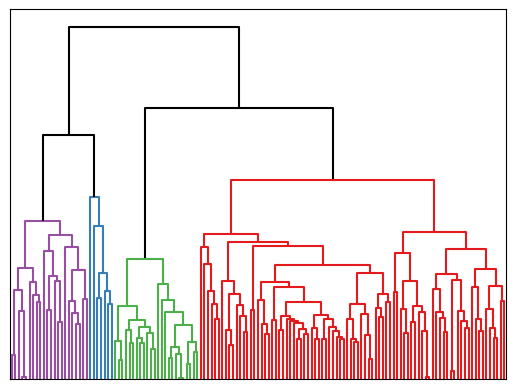

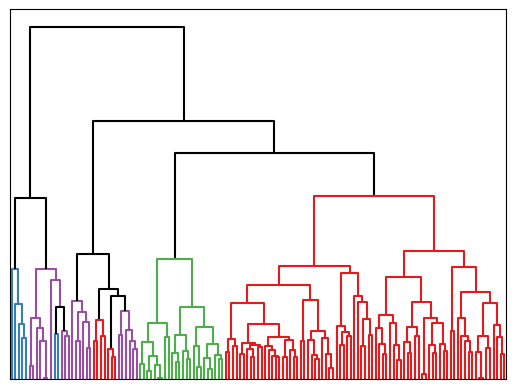

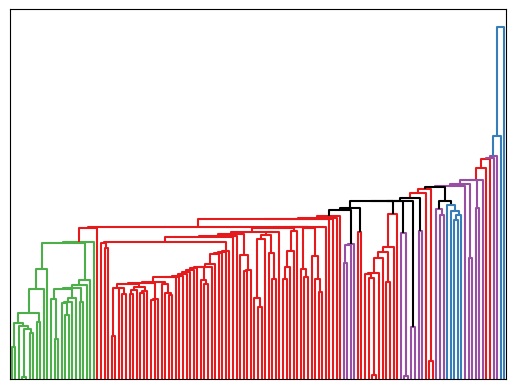

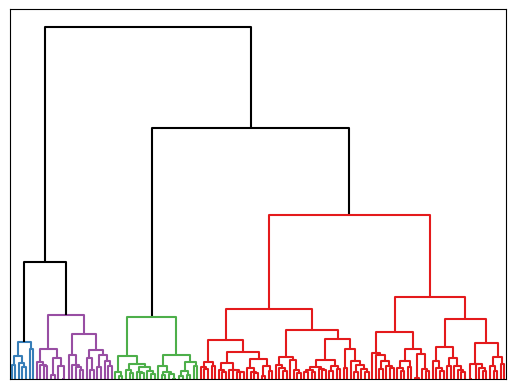

cluster sizes and percentages are:
average2 [110, 29] [0.7913669064748201, 0.20863309352517986]
complete2 [122, 17] [0.8776978417266187, 0.1223021582733813]
single2 [138, 1] [0.9928057553956835, 0.007194244604316547]
ward2 [110, 29] [0.7913669064748201, 0.20863309352517986]
cluster sizes and percentages are:
average4 [86, 7, 24, 22] [0.6187050359712231, 0.050359712230215826, 0.17266187050359713, 0.15827338129496402]
complete4 [79, 17, 19, 24] [0.5683453237410072, 0.1223021582733813, 0.1366906474820144, 0.17266187050359713]
single4 [136, 1, 1, 1] [0.9784172661870504, 0.007194244604316547, 0.007194244604316547, 0.007194244604316547]
ward4 [29, 38, 24, 48] [0.20863309352517986, 0.2733812949640288, 0.17266187050359713, 0.34532374100719426]


In [18]:
# if dataset == "X1":
dataset="X1"
A_main = analysis(dists_x1, n_colours=4, cluster_numbers=[2,4], name="main", dir="test", exclude=["X1_15"], show=False, save=False)


In [ ]:
### Computing purity scores for subtrees of the dendrogram

# Define the subtree by selecting specific cells/indices
# For example, we can look at purity within a specific cluster or branch

# Get the linkage matrices from A_main
linkage_avg = A_main[6][0]
linkage_complete = A_main[6][1]
linkage_single = A_main[6][2]
linkage_ward = A_main[6][3]

# Define subtree indices (example: cells from a specific clustcer)
# You can modify this to select different subtrees
from scipy.cluster.hierarchy import fcluster

# Get cluster assignments for a specific number of clusters
n_clusters_subtree = 2
clusters_avg = fcluster(linkage_avg, n_clusters_subtree, criterion='maxclust')

# Select indices belonging to a specific cluster (e.g., cluster 1)
subtree_cluster_id = 1
subtree_indices = [i for i in range(len(clusters_avg)) if clusters_avg[i] == subtree_cluster_id]

print(f"Subtree contains {len(subtree_indices)} cells")
print(f"Subtree indices: {subtree_indices}")

# Compute purity scores for the subtree
print("\nPurity scores for subtree:")
print("average: " + str(purity(linkage_avg, set(subtree_indices), n_clusters_subtree)[1]))
print("complete: " + str(purity(linkage_complete, set(subtree_indices), n_clusters_subtree)[1]))
print("single: " + str(purity(linkage_single, set(subtree_indices), n_clusters_subtree)[1]))
print("ward: " + str(purity(linkage_ward, set(subtree_indices), n_clusters_subtree)[1]))


NameError: name 'A_main' is not defined

In [27]:
df = pandas.read_csv("X1+Y1/X1+Y1_no_X1_15_df.csv", index_col=0)
df["exp"] = [c[:2] for c in df.index]

In [28]:
px.scatter(df, x="x", y="y", color="exp", width=800, height=600, hover_data=[df.index])